In [1]:
from docx import Document
import json
import os
import pandas as pd
import numpy as np

In [2]:
def extract_json_from_word(file_path):
    """
    Extract JSON data from a Word file.
    """
    doc = Document(file_path)
    json_data_list = []
    for para in doc.paragraphs:
        try:
            json_data = json.loads(para.text.strip()) 
            json_data_list.append(json_data)
        except json.JSONDecodeError:
            continue  
    return json_data_list

def process_word_folder(folder_path):
    """
    Process all Word files in a folder to extract JSON data.
    Ignore temporary files (e.g., those starting with '~$').
    """
    all_data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".docx") and not file_name.startswith("~$"):
            file_path = os.path.join(folder_path, file_name)
            json_data = extract_json_from_word(file_path)
            all_data.extend(json_data)
    return all_data



In [3]:
def preprocess_flight_data(data):
    """
    Preprocess the extracted JSON data for training or testing.
    - Extract relevant fields
    - Calculate departure delay (for training data)
    - Extract temporal features
    """
    processed_data = []  
    
    for record_group in data:
        if isinstance(record_group, list):
            for record in record_group:
                processed_data.append(process_single_flight(record))
        else:
            processed_data.append(process_single_flight(record_group))
    
    return processed_data

def process_single_flight(record):
    """
    Process a single flight record (dictionary).
    """
    processed_record = {}
    
    departure = record.get("departure", {})
    arrival = record.get("arrival", {})
    
    airline = record.get("airline", {})
    flight = record.get("flight", {})
    
    scheduled_time = pd.to_datetime(departure.get("scheduledTime"), errors='coerce')
    actual_runway_time = pd.to_datetime(departure.get("actualRunway"), errors='coerce')
    
    if scheduled_time and actual_runway_time:
        departure_delay = (actual_runway_time - scheduled_time).total_seconds() / 60
    else:
        departure_delay = None
    
    processed_record["departure.scheduledTime"] = scheduled_time
    processed_record["departure.actualRunway"] = actual_runway_time
    processed_record["departure_delay"] = departure_delay
    processed_record["departure.terminal"] = departure.get("terminal")
    processed_record["arrival.iataCode"] = arrival.get("iataCode")
    processed_record["airline.name"] = airline.get("name")
    processed_record["flight.number"] = flight.get("number")
    
    if scheduled_time:
        processed_record["scheduled_hour"] = scheduled_time.hour
        processed_record["scheduled_minute"] = scheduled_time.minute
        processed_record["scheduled_second"] = scheduled_time.second
        processed_record["scheduled_day"] = scheduled_time.day
        processed_record["scheduled_month"] = scheduled_time.month
        processed_record["scheduled_year"] = scheduled_time.year
    else:
        processed_record["scheduled_hour"] = None
        processed_record["scheduled_minute"] = None
        processed_record["scheduled_second"] = None
        processed_record["scheduled_day"] = None
        processed_record["scheduled_month"] = None
        processed_record["scheduled_year"] = None
    
    if actual_runway_time:
        processed_record["actual_hour"] = actual_runway_time.hour
        processed_record["actual_minute"] = actual_runway_time.minute
        processed_record["actual_second"] = actual_runway_time.second
        processed_record["actual_day"] = actual_runway_time.day
        processed_record["actual_month"] = actual_runway_time.month
        processed_record["actual_year"] = actual_runway_time.year
    else:
        processed_record["actual_hour"] = None
        processed_record["actual_minute"] = None
        processed_record["actual_second"] = None
        processed_record["actual_day"] = None
        processed_record["actual_month"] = None
        processed_record["actual_year"] = None
    
    return processed_record


In [9]:
train_folder = "Train"      
test_folder = "Test"        
weather_folder = "Weather"

print("Processing Train Data...")
train_data = process_word_folder("Train")  
train_processed = preprocess_flight_data(train_data)  

print("Processing Test Data...")
test_data = process_word_folder("Test")  
test_processed = preprocess_flight_data(test_data)  

train = pd.DataFrame(train_processed)
test = pd.DataFrame(test_processed)

In [11]:
import os
import pandas as pd

def preprocess_monthly_weather_data(file_path, start_date):
    """
    Preprocess a single Excel file containing monthly weather data.
    """
    try:
        df = pd.read_excel(file_path, header=None)
        
        days_row = df.iloc[1, 0]
        days = days_row.split()[1:]  

        
        num_days = len(days)
        datetimes = pd.date_range(start=start_date, periods=num_days, freq='D')

        processed_data = {
            "datetime": datetimes,
            "temp_max": [],
            "temp_avg": [],
            "temp_min": [],
            "dew_max": [],
            "dew_avg": [],
            "dew_min": [],
            "humidity_max": [],
            "humidity_avg": [],
            "humidity_min": [],
            "wind_max": [],
            "wind_avg": [],
            "wind_min": [],
            "pressure_max": [],
            "pressure_avg": [],
            "pressure_min": [],
            "precipitation_total": [],
        }

        attribute_mapping = {
            1: ("temp_max", "temp_avg", "temp_min"),
            2: ("dew_max", "dew_avg", "dew_min"),
            3: ("humidity_max", "humidity_avg", "humidity_min"),
            4: ("wind_max", "wind_avg", "wind_min"),
            5: ("pressure_max", "pressure_avg", "pressure_min"),
            6: ("precipitation_total", None, None),  
        }

        for col_index, attr_names in attribute_mapping.items():
            # Extract raw values
            raw_values = df.iloc[1, col_index]
            
            if "Max Avg Min" in raw_values:
                data_values = raw_values.split("Max Avg Min")[-1].strip().split()
                processed_data[attr_names[0]].extend(data_values[::3])  # max
                processed_data[attr_names[1]].extend(data_values[1::3])  # avg
                processed_data[attr_names[2]].extend(data_values[2::3])  # min
            elif "Total" in raw_values:
                data_values = raw_values.split("Total")[-1].strip().split()
                processed_data[attr_names[0]].extend(data_values)  # Total

        return pd.DataFrame(processed_data)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return pd.DataFrame()

def preprocess_weather_folder(folder_path, start_year=2023, start_month=7, limit=13):
    """
    Process weather data from the first `limit` Excel files in the folder.
    """
    weather_data = pd.DataFrame()

    files = sorted([f for f in os.listdir(folder_path) if f.endswith(".xlsx")])
    
    for idx, file_name in enumerate(files[:limit]):
        file_path = os.path.join(folder_path, file_name)

        month = (start_month + idx - 1) % 12 + 1
        year = start_year + (start_month + idx - 1) // 12
        start_date = pd.Timestamp(year, month, 1)

        monthly_data = preprocess_monthly_weather_data(file_path, start_date)
        weather_data = pd.concat([weather_data, monthly_data], ignore_index=True)
    
    return weather_data

weather_folder = r"C:\Users\Abdullah\Desktop\ML_PROJ\Weather"
weather = preprocess_weather_folder(weather_folder)

print("Processed Weather DataFrame:")
print(weather.head())


Processed Weather DataFrame:
    datetime temp_max temp_avg temp_min dew_max dew_avg dew_min humidity_max  \
0 2023-07-01       97     88.8       81      77    74.5      72           74   
1 2023-07-02       99     91.5       82      79    75.8      75           79   
2 2023-07-03      102     91.7       77      81    77.0      73          100   
3 2023-07-04       97     88.5       81      77    74.3      73           79   
4 2023-07-05       86     76.0       68      79    72.9      68          100   

  humidity_avg humidity_min wind_max wind_avg wind_min pressure_max  \
0         63.4           47       14      8.9        5         28.8   
1         61.3           47       12      6.7        0         28.8   
2         63.7           45       35     11.0        0         28.8   
3         64.0           47       32     13.0        0         28.8   
4         90.2           70       40     15.0        5         28.8   

  pressure_avg pressure_min precipitation_total  
0         28.

In [15]:
train['datetime'] = pd.to_datetime(train['departure.scheduledTime']).dt.date
test['datetime'] = pd.to_datetime(test['departure.scheduledTime']).dt.date
weather['datetime'] = pd.to_datetime(weather['datetime']).dt.date

train_merged = train.merge(weather, on='datetime', how='inner')
test_merged=test.merge(weather, on='datetime', how='inner')



In [50]:
test_merged.dtypes

departure.scheduledTime    datetime64[ns]
departure.actualRunway     datetime64[ns]
departure_delay                   float64
departure.terminal                 object
arrival.iataCode                   object
airline.name                       object
flight.number                      object
scheduled_hour                    float64
scheduled_minute                  float64
scheduled_second                  float64
scheduled_day                     float64
scheduled_month                   float64
scheduled_year                    float64
actual_hour                       float64
actual_minute                     float64
actual_second                     float64
actual_day                        float64
actual_month                      float64
actual_year                       float64
datetime                   datetime64[ns]
temp_max                          float64
temp_avg                          float64
temp_min                          float64
dew_max                           

In [51]:
train_merged.dtypes

departure.scheduledTime    datetime64[ns]
departure.actualRunway     datetime64[ns]
departure_delay                   float64
departure.terminal                 object
arrival.iataCode                   object
airline.name                       object
flight.number                      object
scheduled_hour                    float64
scheduled_minute                  float64
scheduled_second                  float64
scheduled_day                     float64
scheduled_month                   float64
scheduled_year                    float64
actual_hour                       float64
actual_minute                     float64
actual_second                     float64
actual_day                        float64
actual_month                      float64
actual_year                       float64
datetime                   datetime64[ns]
temp_max                          float64
temp_avg                          float64
temp_min                          float64
dew_max                           

In [19]:
train_merged

departure.scheduledTime departure.actualRunway  departure_delay  \
0         2023-07-20 20:50:00    2023-07-20 20:15:00            -35.0   
1         2023-07-20 11:35:00                    NaT              NaN   
2         2023-07-20 22:20:00                    NaT              NaN   
3         2023-07-20 21:10:00                    NaT              NaN   
4         2023-07-20 09:55:00    2023-07-20 10:09:00             14.0   
...                       ...                    ...              ...   
49404     2023-11-13 21:35:00    2023-11-13 22:04:00             29.0   
49405     2023-11-13 09:35:00                    NaT              NaN   
49406     2023-11-13 23:00:00                    NaT              NaN   
49407     2023-11-13 06:35:00    2023-11-13 06:24:00            -11.0   
49408     2023-11-13 02:55:00    2023-11-13 03:06:00             11.0   

      departure.terminal arrival.iataCode                     airline.name  \
0                      m              ruh                           saudia   
1                      m              dxb                       serene air   
2                      m              dmm  pakistan international airlines   
3                      m              doh                  british airways   
4                      m              doh                    qatar airways   
...                  ...              ...                              ...   
49404                  m              dmm  pakistan international airlines   
49405               main              dxb                       air canada   
49406                  m              jed                          airblue   
49407                  m              cmb               srilankan airlines   
49408                  m              doh                         oman air   

      flight.number  scheduled_hour  scheduled_minute  scheduled_second  ...  \
0               737              20                50                 0  ...   
1               723              11                35                 0  ...   
2               247              22                20                 0  ...   
3              6333              21                10                 0  ...   
4               629               9                55                 0  ...   
...             ...             ...               ...               ...  ...   
49404           247              21                35                 0  ...   
49405          7579               9                35                 0  ...   
49406           470              23                 0                 0  ...   
49407           154               6                35                 0  ...   
49408          6030               2                55                 0  ...   

       humidity_max  humidity_avg  humidity_min  wind_max  wind_avg  wind_min  \
0                89          76.0            63        12       5.3         0   
1                89          76.0            63        12       5.3         0   
2                89          76.0            63        12       5.3         0   
3                89          76.0            63        12       5.3         0   
4                89          76.0            63        12       5.3         0   
...             ...           ...           ...       ...       ...       ...   
49404            94          65.2            41        12       5.4         0   
49405            94          65.2            41        12       5.4         0   
49406            94          65.2            41        12       5.4         0   
49407            94          65.2            41        12       5.4         0   
49408            94          65.2            41        12       5.4         0   

       pressure_max  pressure_avg  pressure_min precipitation_total  
0              28.9          28.8          28.7                0.00  
1              28.9          28.8          28.7                0.00  
2              28.9          28.8          28.7 

In [20]:
weather_cols = [
    'temp_max', 'temp_avg', 'temp_min',
    'dew_max', 'dew_avg', 'dew_min',
    'humidity_max', 'humidity_avg', 'humidity_min',
    'wind_max', 'wind_avg', 'wind_min',
    'pressure_max', 'pressure_avg', 'pressure_min',
    'precipitation_total'
]

for col in weather_cols:
    train_merged[col] = pd.to_numeric(train_merged[col], errors='coerce') 


In [22]:
weather_cols = [
    'temp_max', 'temp_avg', 'temp_min',
    'dew_max', 'dew_avg', 'dew_min',
    'humidity_max', 'humidity_avg', 'humidity_min',
    'wind_max', 'wind_avg', 'wind_min',
    'pressure_max', 'pressure_avg', 'pressure_min',
    'precipitation_total'
]

for col in weather_cols:
    test_merged[col] = pd.to_numeric(test_merged[col], errors='coerce') 


In [23]:
train_merged['datetime'] = pd.to_datetime(train_merged['datetime'], errors='coerce')  
test_merged['datetime'] = pd.to_datetime(test_merged['datetime'], errors='coerce')  


In [27]:
train_merged.isnull().sum(),test_merged.isnull().sum()

(departure.scheduledTime        0
 departure.actualRunway     19672
 departure_delay            19672
 departure.terminal         20777
 arrival.iataCode               0
 airline.name                   0
 flight.number                  0
 scheduled_hour                 0
 scheduled_minute               0
 scheduled_second               0
 scheduled_day                  0
 scheduled_month                0
 scheduled_year                 0
 actual_hour                19672
 actual_minute              19672
 actual_second              19672
 actual_day                 19672
 actual_month               19672
 actual_year                19672
 datetime                       0
 temp_max                       0
 temp_avg                       0
 temp_min                       0
 dew_max                        0
 dew_avg                        0
 dew_min                        0
 humidity_max                   0
 humidity_avg                   0
 humidity_min                   0
 wind_max     

In [32]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np


numeric_cols = train_merged.select_dtypes(include=['float64', 'int64']).columns

numeric_imputer = SimpleImputer(strategy='mean')

train_merged[numeric_cols] = numeric_imputer.fit_transform(train_merged[numeric_cols])

train_merged.loc[train_merged['departure.actualRunway'] < train_merged['departure.scheduledTime'], 'departure_delay'] = 0

train_merged.loc[train_merged['departure.actualRunway'].isna(), 'departure_delay'] = -1

train_merged['departure.terminal'] = train_merged['departure.terminal'].fillna('Unknown')



In [33]:
train_merged

departure.scheduledTime departure.actualRunway  departure_delay  \
0         2023-07-20 20:50:00    2023-07-20 20:15:00              0.0   
1         2023-07-20 11:35:00                    NaT             -1.0   
2         2023-07-20 22:20:00                    NaT             -1.0   
3         2023-07-20 21:10:00                    NaT             -1.0   
4         2023-07-20 09:55:00    2023-07-20 10:09:00             14.0   
...                       ...                    ...              ...   
49404     2023-11-13 21:35:00    2023-11-13 22:04:00             29.0   
49405     2023-11-13 09:35:00                    NaT             -1.0   
49406     2023-11-13 23:00:00                    NaT             -1.0   
49407     2023-11-13 06:35:00    2023-11-13 06:24:00              0.0   
49408     2023-11-13 02:55:00    2023-11-13 03:06:00             11.0   

      departure.terminal arrival.iataCode                     airline.name  \
0                      m              ruh                           saudia   
1                      m              dxb                       serene air   
2                      m              dmm  pakistan international airlines   
3                      m              doh                  british airways   
4                      m              doh                    qatar airways   
...                  ...              ...                              ...   
49404                  m              dmm  pakistan international airlines   
49405               main              dxb                       air canada   
49406                  m              jed                          airblue   
49407                  m              cmb               srilankan airlines   
49408                  m              doh                         oman air   

      flight.number  scheduled_hour  scheduled_minute  scheduled_second  ...  \
0               737            20.0              50.0               0.0  ...   
1               723            11.0              35.0               0.0  ...   
2               247            22.0              20.0               0.0  ...   
3              6333            21.0              10.0               0.0  ...   
4               629             9.0              55.0               0.0  ...   
...             ...             ...               ...               ...  ...   
49404           247            21.0              35.0               0.0  ...   
49405          7579             9.0              35.0               0.0  ...   
49406           470            23.0               0.0               0.0  ...   
49407           154             6.0              35.0               0.0  ...   
49408          6030             2.0              55.0               0.0  ...   

       humidity_max  humidity_avg  humidity_min  wind_max  wind_avg  wind_min  \
0              89.0          76.0          63.0      12.0       5.3       0.0   
1              89.0          76.0          63.0      12.0       5.3       0.0   
2              89.0          76.0          63.0      12.0       5.3       0.0   
3              89.0          76.0          63.0      12.0       5.3       0.0   
4              89.0          76.0          63.0      12.0       5.3       0.0   
...             ...           ...           ...       ...       ...       ...   
49404          94.0          65.2          41.0      12.0       5.4       0.0   
49405          94.0          65.2          41.0      12.0       5.4       0.0   
49406          94.0          65.2          41.0      12.0       5.4       0.0   
49407          94.0          65.2          41.0      12.0       5.4       0.0   
49408          94.0          65.2          41.0      12.0       5.4       0.0   

       pressure_max  pressure_avg  pressure_min precipitation_total  
0              28.9          28.8          28.7                 0.0  
1              28.9          28.8          28.7                 0.0  
2              28.9          28.8          28.7 

In [34]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np


numeric_cols = test_merged.select_dtypes(include=['float64', 'int64']).columns

numeric_imputer = SimpleImputer(strategy='mean')

test_merged[numeric_cols] = numeric_imputer.fit_transform(test_merged[numeric_cols])

test_merged.loc[test_merged['departure.actualRunway'] < test_merged['departure.scheduledTime'], 'departure_delay'] = 0

test_merged.loc[test_merged['departure.actualRunway'].isna(), 'departure_delay'] = -1

test_merged['departure.terminal'] = test_merged['departure.terminal'].fillna('Unknown')




In [35]:
test_merged

departure.scheduledTime departure.actualRunway  departure_delay  \
0         2023-07-17 20:35:00    2023-07-17 20:46:00             11.0   
1         2023-07-17 09:55:00                    NaT             -1.0   
2         2023-07-17 09:55:00                    NaT             -1.0   
3         2023-07-17 03:30:00    2023-07-17 03:52:00             22.0   
4         2023-07-17 06:00:00                    NaT             -1.0   
...                       ...                    ...              ...   
14308     2023-11-04 02:55:00    2023-11-04 03:14:00             19.0   
14309     2023-11-04 07:00:00    2023-11-04 07:12:00             12.0   
14310     2023-11-04 19:50:00                    NaT             -1.0   
14311     2023-11-04 04:05:00    2023-11-04 04:33:00             28.0   
14312     2023-11-04 15:05:00                    NaT             -1.0   

      departure.terminal arrival.iataCode                     airline.name  \
0                Unknown              khi                        flyjinnah   
1                      m              doh                    qatar airways   
2                      m              doh                  royal jordanian   
3                      m              doh                           iberia   
4                Unknown              ist                 turkish airlines   
...                  ...              ...                              ...   
14308                  m              doh                         oman air   
14309                  m              gyd  pakistan international airlines   
14310                  m              khi                       serene air   
14311                  m              ruh                           flynas   
14312            Unknown              khi                        flyjinnah   

      flight.number  scheduled_hour  scheduled_minute  scheduled_second  ...  \
0               847            20.0              35.0               0.0  ...   
1               629             9.0              55.0               0.0  ...   
2              3836             9.0              55.0               0.0  ...   
3              7913             3.0              30.0               0.0  ...   
4               715             6.0               0.0               0.0  ...   
...             ...             ...               ...               ...  ...   
14308          6030             2.0              55.0               0.0  ...   
14309           159             7.0               0.0               0.0  ...   
14310           523            19.0              50.0               0.0  ...   
14311           318             4.0               5.0               0.0  ...   
14312           843            15.0               5.0               0.0  ...   

       humidity_max  humidity_avg  humidity_min  wind_max  wind_avg  wind_min  \
0              89.0          71.3          59.0      12.0       6.9       0.0   
1              89.0          71.3          59.0      12.0       6.9       0.0   
2              89.0          71.3          59.0      12.0       6.9       0.0   
3              89.0          71.3          59.0      12.0       6.9       0.0   
4              89.0          71.3          59.0      12.0       6.9       0.0   
...             ...           ...           ...       ...       ...       ...   
14308          89.0          74.7          66.0      40.0      13.6       0.0   
14309          89.0          74.7          66.0      40.0      13.6       0.0   
14310          89.0          74.7          66.0      40.0      13.6       0.0   
14311          89.0          74.7          66.0      40.0      13.6       0.0   
14312          89.0          74.7          66.0      40.0      13.6       0.0   

       pressure_max  pressure_avg  pressure_min precipitation_total  
0              28.8          28.8          28.7                 0.0  
1              28.8          28.8          28.7                 0.0  
2              28.8          28.8          28.7 

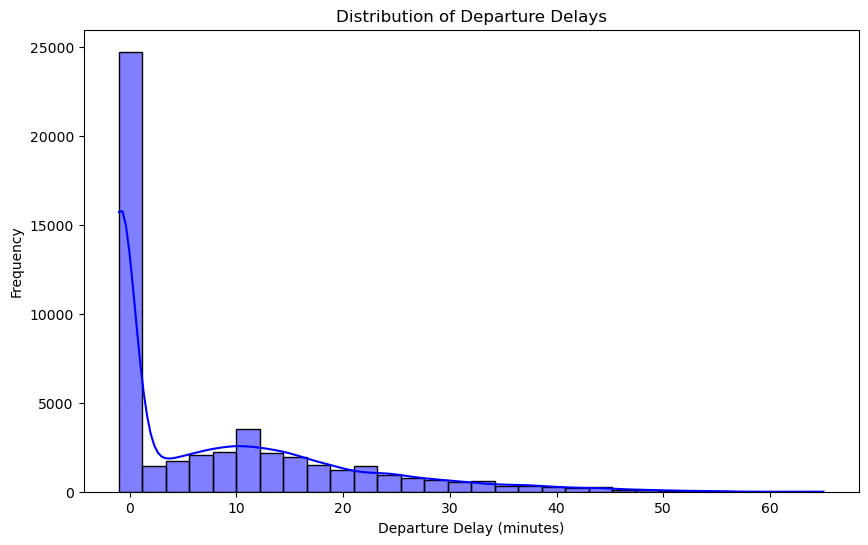

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train_merged['departure_delay'], bins=30, kde=True, color='blue')
plt.title('Distribution of Departure Delays')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.show()


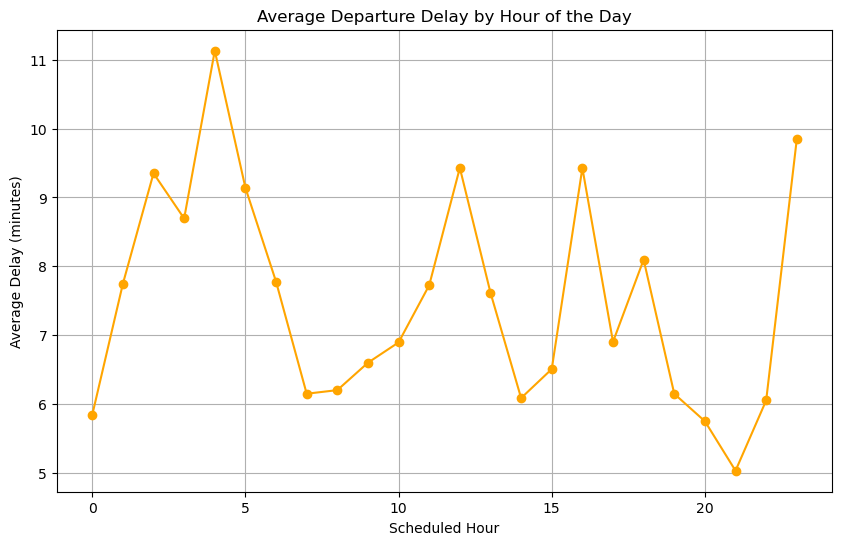

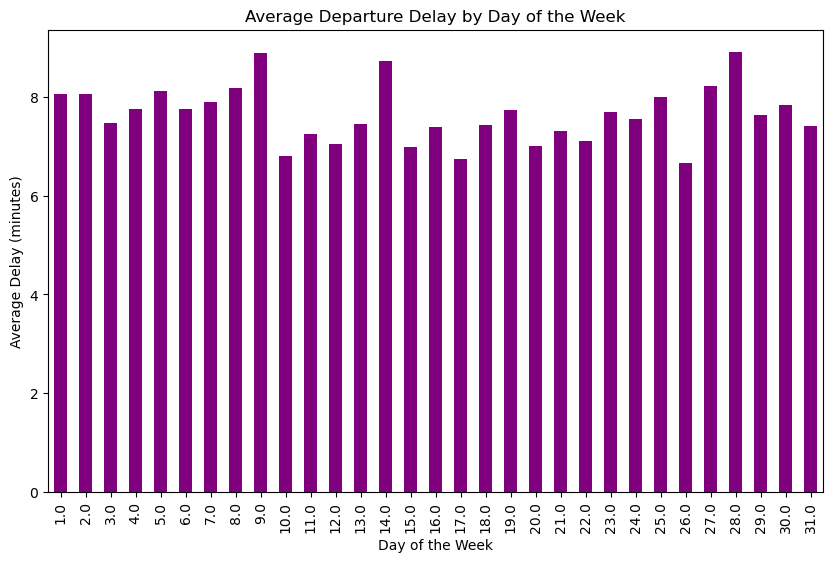

In [37]:
delay_by_hour = train_merged.groupby('scheduled_hour')['departure_delay'].mean()

plt.figure(figsize=(10, 6))
delay_by_hour.plot(kind='line', marker='o', color='orange')
plt.title('Average Departure Delay by Hour of the Day')
plt.xlabel('Scheduled Hour')
plt.ylabel('Average Delay (minutes)')
plt.grid()
plt.show()

delay_by_day = train_merged.groupby('scheduled_day')['departure_delay'].mean()
plt.figure(figsize=(10, 6))
delay_by_day.plot(kind='bar', color='purple')
plt.title('Average Departure Delay by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (minutes)')
plt.show()


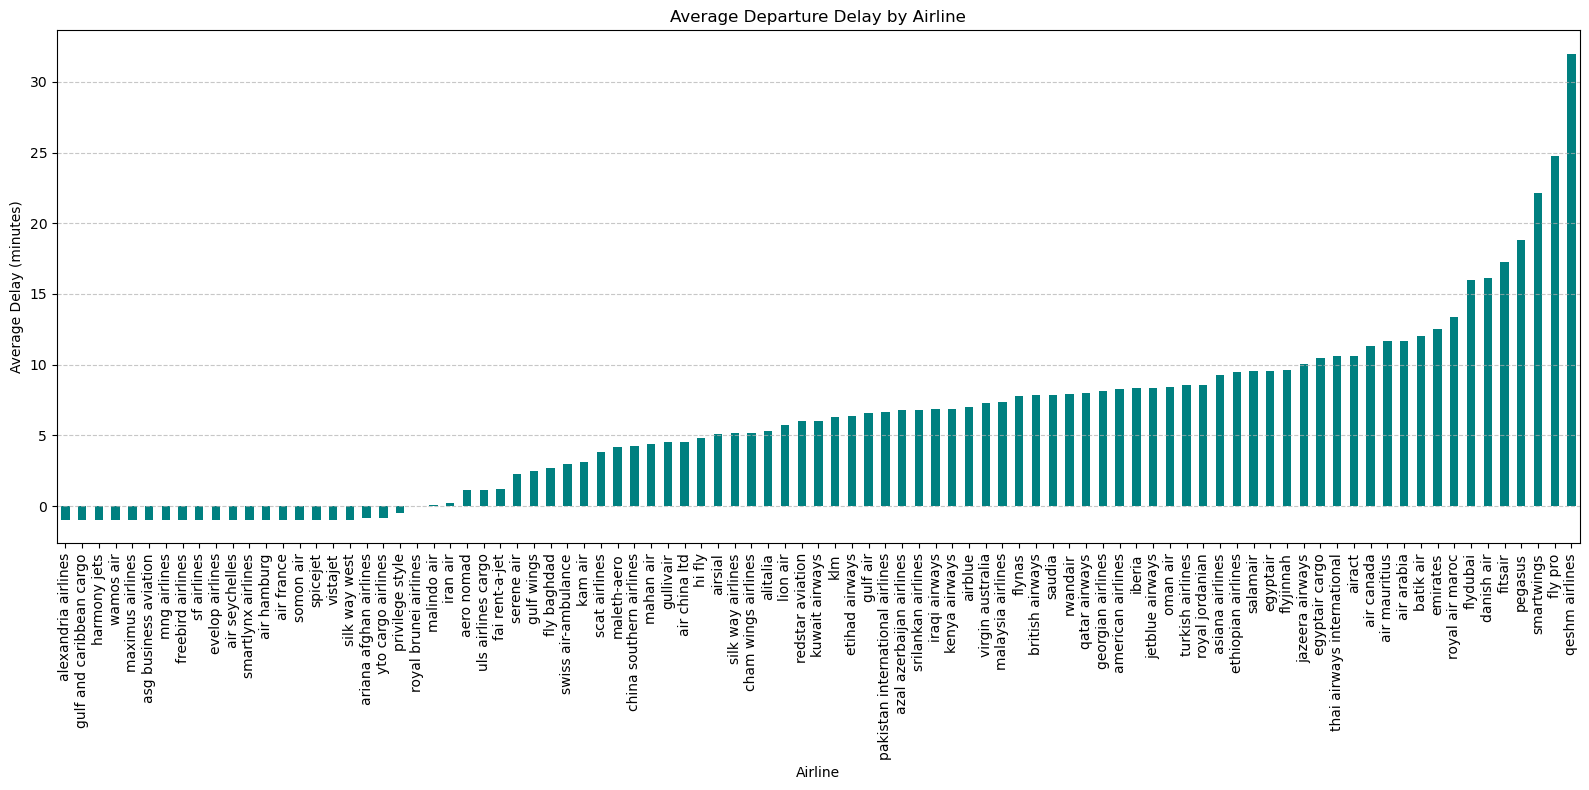

In [43]:
delay_by_airline = train_merged.groupby('airline.name')['departure_delay'].mean().sort_values()

plt.figure(figsize=(16, 8))  
delay_by_airline.plot(kind='bar', color='teal')  
plt.title('Average Departure Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=90)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout()  
plt.show()


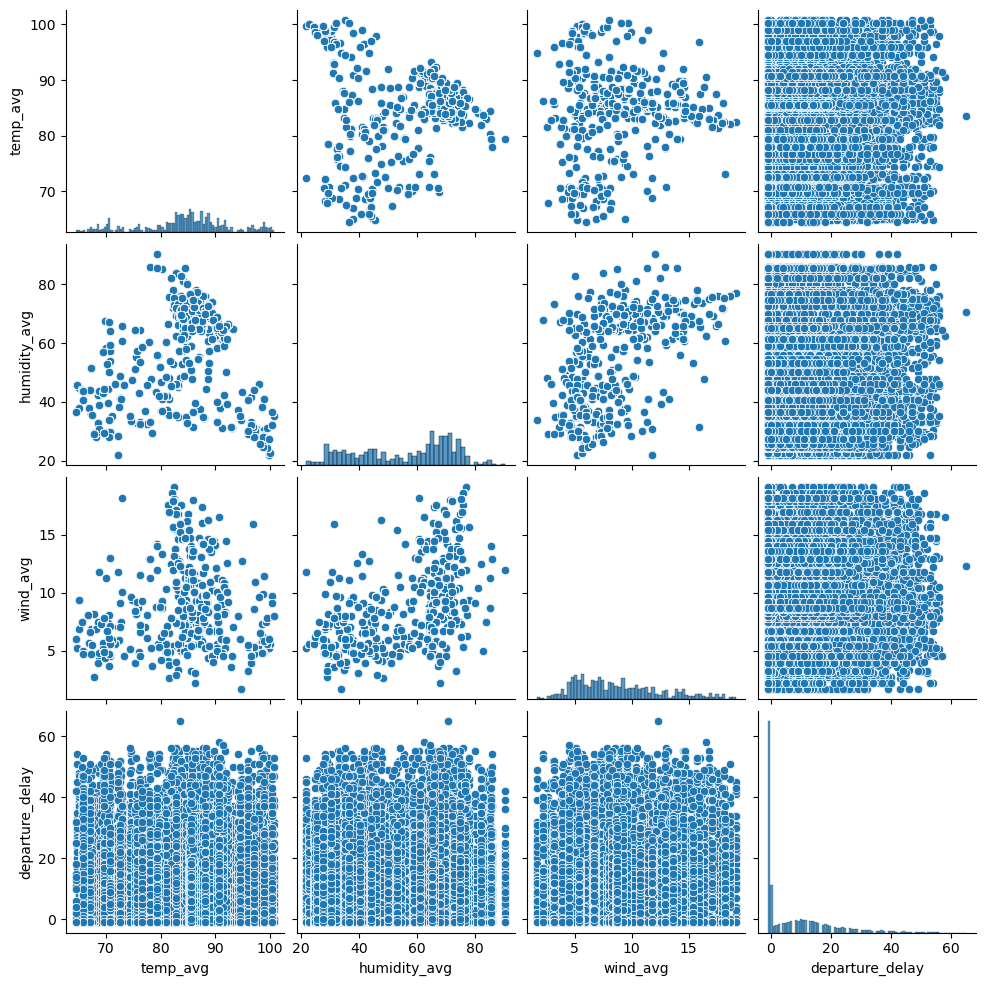

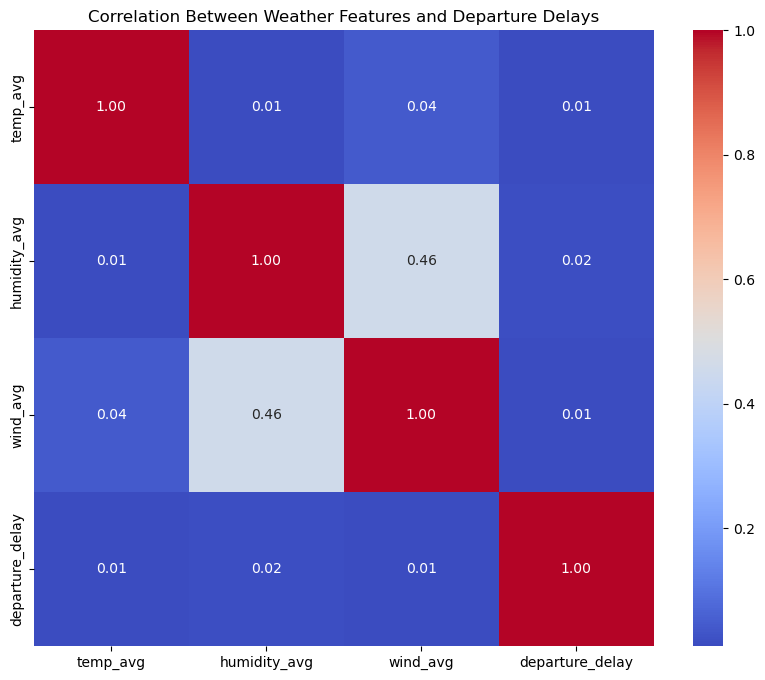

In [42]:
weather_cols = ['temp_avg', 'humidity_avg', 'wind_avg', 'departure_delay']
sns.pairplot(train_merged[weather_cols])
plt.show()

plt.figure(figsize=(10, 8))
corr_matrix = train_merged[weather_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Weather Features and Departure Delays')
plt.show()


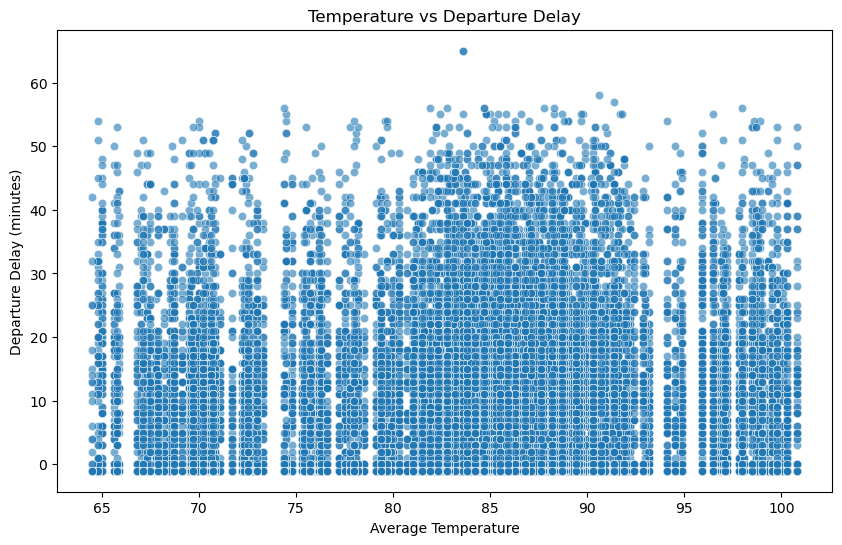

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp_avg', y='departure_delay', data=train_merged, alpha=0.6)
plt.title('Temperature vs Departure Delay')
plt.xlabel('Average Temperature')
plt.ylabel('Departure Delay (minutes)')
plt.show()


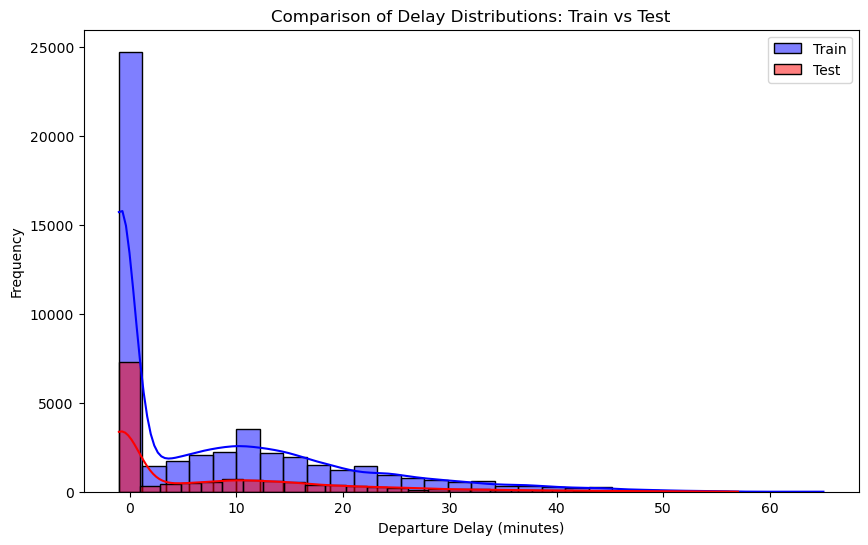

<Figure size 1200x600 with 0 Axes>

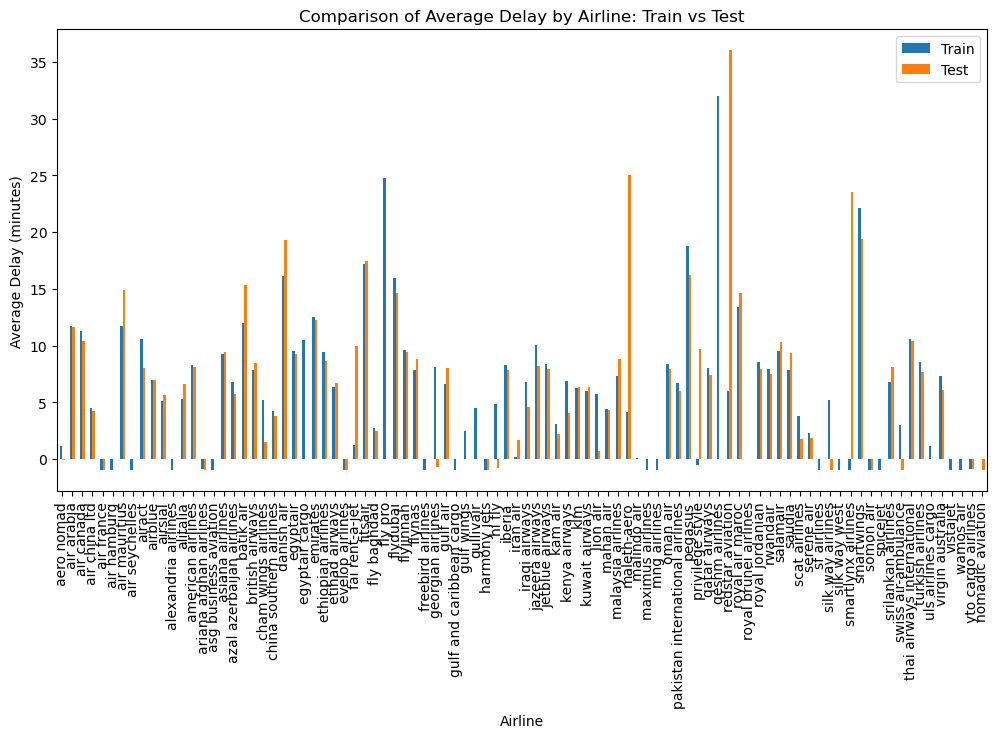

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(train_merged['departure_delay'], bins=30, kde=True, color='blue', label='Train')
sns.histplot(test_merged['departure_delay'], bins=30, kde=True, color='red', label='Test')
plt.title('Comparison of Delay Distributions: Train vs Test')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

train_airline_delay = train_merged.groupby('airline.name')['departure_delay'].mean()
test_airline_delay = test_merged.groupby('airline.name')['departure_delay'].mean()

plt.figure(figsize=(12, 6))
pd.concat([train_airline_delay, test_airline_delay], axis=1, keys=['Train', 'Test']).plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Average Delay by Airline: Train vs Test')
plt.xlabel('Airline')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=90)
plt.show()


In [155]:
numeric_features = train_.select_dtypes(include=['float64', 'int64']).columns.tolist()

if 'departure_delay' in numeric_features:
    numeric_features.remove('departure_delay')

X = train_[numeric_features]


In [120]:
train_.drop(columns=['precipitation_total'], inplace=True)

In [121]:
test_.drop(columns=['precipitation_total'], inplace=True)

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_2884\1059222565.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['binary_target'] = (binary_data['departure_delay'] > 0).astype(int)


Accuracy: 0.925857431069267
Precision: 0.9226266691055424
Recall: 0.9964440932437771
F1 Score: 0.9581156805014721


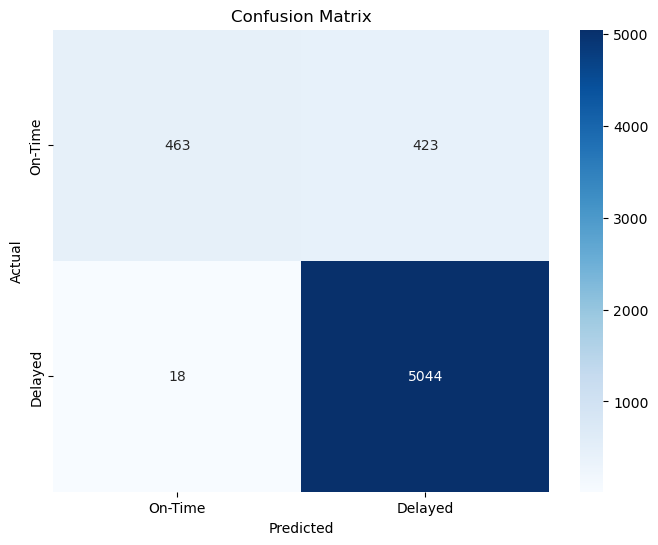

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

binary_data = train_[train_['departure_delay'] >= 0]

binary_data['binary_target'] = (binary_data['departure_delay'] > 0).astype(int)


X = binary_data[numeric_features]
y = binary_data['binary_target']

X = X.apply(pd.to_numeric, errors='coerce')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

binary_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')
binary_classifier.fit(X_train, y_train)

y_pred = binary_classifier.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["On-Time", "Delayed"], yticklabels=["On-Time", "Delayed"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Classification Report:
                 precision    recall  f1-score   support

Moderate Delay       0.88      0.11      0.19        64
      No Delay       0.94      0.54      0.68       886
   Short Delay       0.92      0.99      0.95      4998

      accuracy                           0.92      5948
     macro avg       0.91      0.55      0.61      5948
  weighted avg       0.92      0.92      0.91      5948



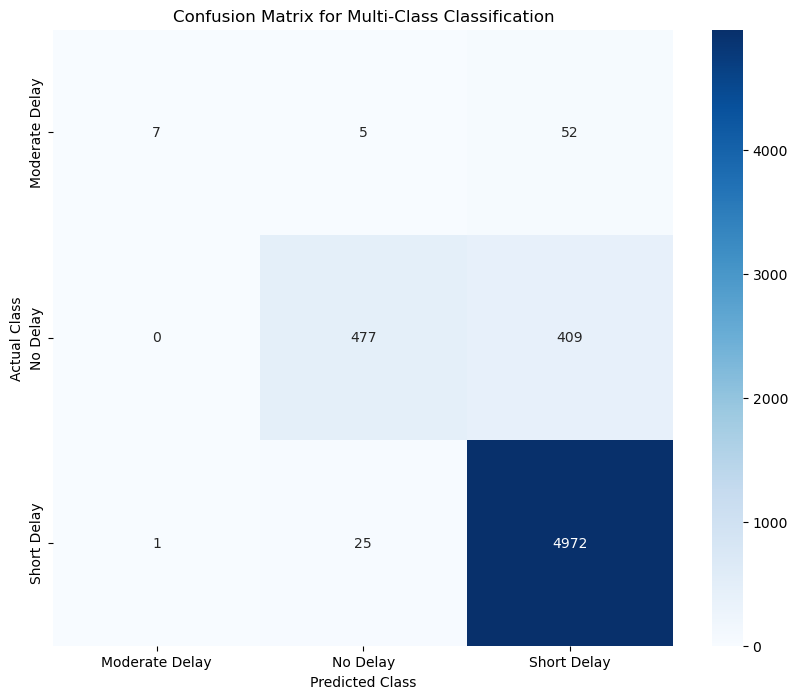

In [157]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

multi_class_data = train_[train_['departure_delay'] >= 0].copy()

multi_class_data['multi_class_target'] = 'No Delay'
multi_class_data.loc[multi_class_data['departure_delay'] > 0, 'multi_class_target'] = 'Short Delay'
multi_class_data.loc[multi_class_data['departure_delay'] > 45, 'multi_class_target'] = 'Moderate Delay'
multi_class_data.loc[multi_class_data['departure_delay'] > 175, 'multi_class_target'] = 'Long Delay'

le = LabelEncoder()
multi_class_data['multi_class_target'] = le.fit_transform(multi_class_data['multi_class_target'])

numeric_features = [col for col in train_.select_dtypes(include=['float64', 'int64']).columns if col != 'departure_delay']
X = multi_class_data[numeric_features].copy()
y = multi_class_data['multi_class_target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

multi_class_classifier = RandomForestClassifier(random_state=42)
multi_class_classifier.fit(X_train, y_train)

y_pred = multi_class_classifier.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Multi-Class Classification")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


Training Mean Absolute Error (MAE): 0.6191979486317205
Training Root Mean Square Error (RMSE): 1.801807817953365
Validation Mean Absolute Error (MAE): 1.6456035642232683
Validation Root Mean Square Error (RMSE): 4.612349721810764
Validation R² (Accuracy): 0.8345525633729478


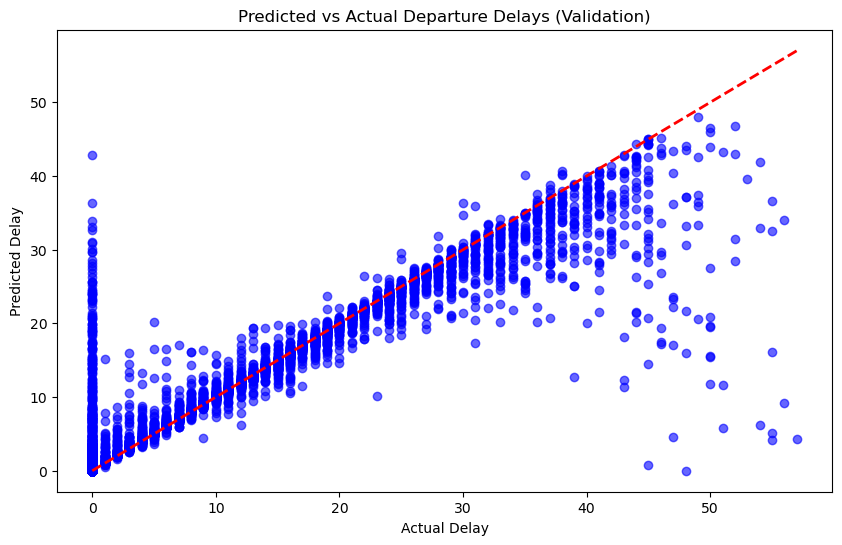

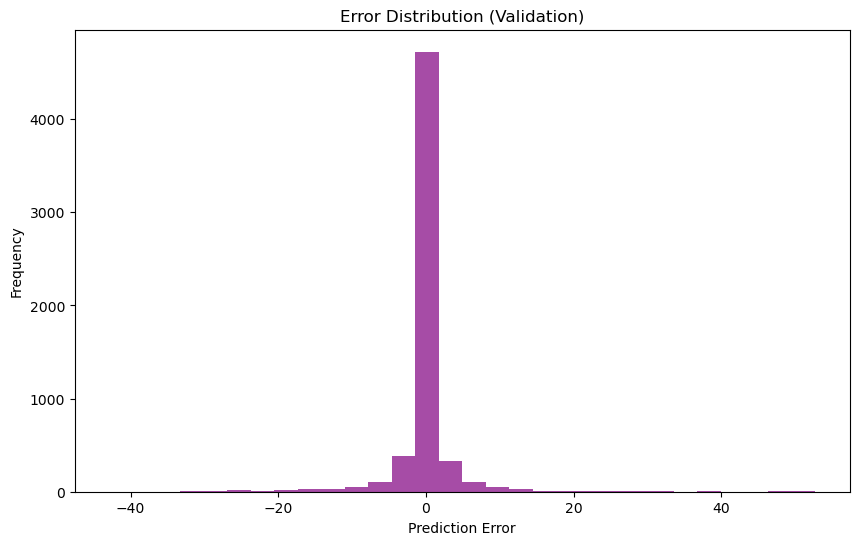

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

regression_data = train_[train_['departure_delay'] >= 0].copy()

X = regression_data[numeric_features]
y = regression_data['departure_delay']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = regressor.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2_val = r2_score(y_val, y_val_pred)

print("Training Mean Absolute Error (MAE):", train_mae)
print("Training Root Mean Square Error (RMSE):", train_rmse)
print("Validation Mean Absolute Error (MAE):", val_mae)
print("Validation Root Mean Square Error (RMSE):", val_rmse)
print("Validation R² (Accuracy):", r2_val)


plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='blue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2)
plt.title('Predicted vs Actual Departure Delays (Validation)')
plt.xlabel('Actual Delay')
plt.ylabel('Predicted Delay')
plt.show()

errors = y_val - y_val_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='purple', alpha=0.7)
plt.title('Error Distribution (Validation)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


C:\Users\Abdullah\AppData\Local\Temp\ipykernel_2884\361064008.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_data['binary_target'] = (binary_data['departure_delay'] > 0).astype(int)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters for Binary Model: {'max_depth': 38, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 444}
Cross-Validation Accuracy (Mean): 0.92
Optimized Model Accuracy: 0.9260255548083389
Optimized Model Precision: 0.9232600732600733
Optimized Model Recall: 0.99585144211774
Optimized Model F1 Score: 0.9581828549705379


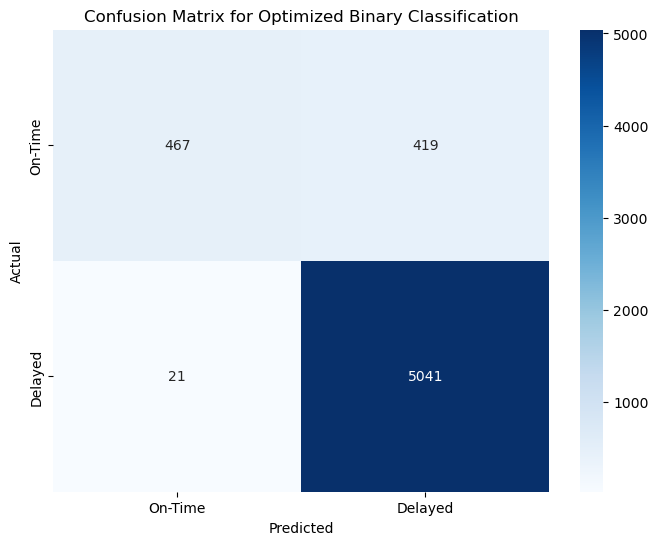

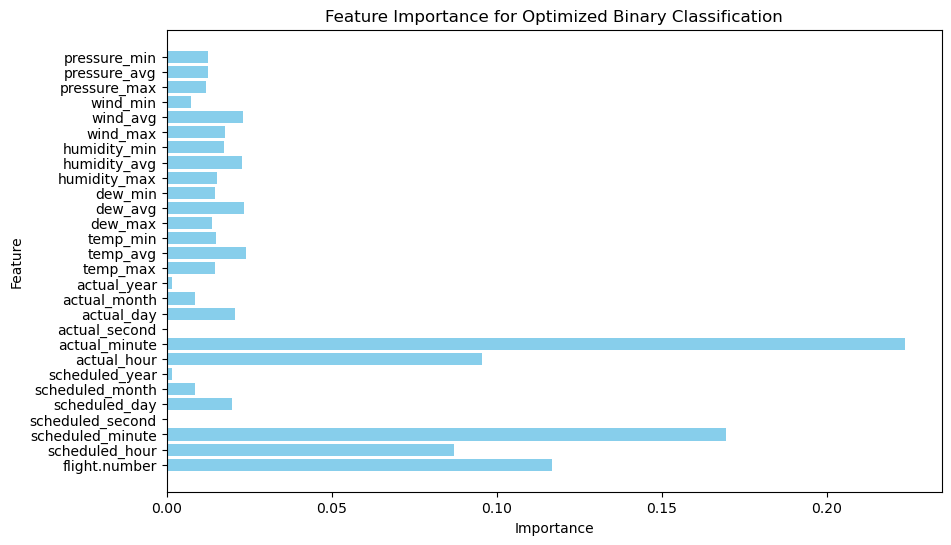

In [151]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

binary_data = train_[train_['departure_delay'] >= 0]

binary_data['binary_target'] = (binary_data['departure_delay'] > 0).astype(int)

X = binary_data[numeric_features]
y = binary_data['binary_target']

X = X.apply(pd.to_numeric, errors='coerce')

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

random_search_binary = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search_binary.fit(X_train, y_train)

best_binary_clf = random_search_binary.best_estimator_
print("Best Hyperparameters for Binary Model:", random_search_binary.best_params_)

cv_scores_binary = cross_val_score(best_binary_clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (Mean): {cv_scores_binary.mean():.2f}")

y_pred_optimized_binary = best_binary_clf.predict(X_test)

print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_optimized_binary))
print("Optimized Model Precision:", precision_score(y_test, y_pred_optimized_binary))
print("Optimized Model Recall:", recall_score(y_test, y_pred_optimized_binary))
print("Optimized Model F1 Score:", f1_score(y_test, y_pred_optimized_binary))

cm_binary = confusion_matrix(y_test, y_pred_optimized_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt="d", cmap="Blues", xticklabels=["On-Time", "Delayed"], yticklabels=["On-Time", "Delayed"])
plt.title("Confusion Matrix for Optimized Binary Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

feature_importances = best_binary_clf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances, color='skyblue')
plt.title("Feature Importance for Optimized Binary Classification")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [168]:
# # Make predictions for binary classification on test data
# X_test_data = test_[numeric_features]

# # Ensure all selected features are numeric
# X_test_data = X_test_data.apply(pd.to_numeric, errors='coerce')

# # Fill missing values
# X_test_data = X_test_data.fillna(X.mean())

# # Predict using the optimized model
# binary_predictions = best_binary_clf.predict(X_test_data)

# # Convert predictions to human-readable format
# binary_predictions = ["on-time" if pred == 0 else "delayed" for pred in binary_predictions]

# # Create submission dataframe
# binary_submission = pd.DataFrame({
#     'ID': range(1, len(binary_predictions) + 1),  # Create an ID column starting from 1
#     'delay': binary_predictions
# })

# # Display the first few rows of the submission dataframe
# print(binary_submission.head())


# # Optionally save to CSV
# binary_submission.to_csv('bin.csv', index=False)
# print("Binary classification submission saved as 'binary_submission.csv'.")


Best Hyperparameters for Multi-Class Model: {'max_depth': 38, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 138}
Optimized Model Performance
Classification Report:
                 precision    recall  f1-score   support

Moderate Delay       0.88      0.11      0.19        64
      No Delay       0.95      0.56      0.70       886
   Short Delay       0.92      1.00      0.96      4998

      accuracy                           0.92      5948
     macro avg       0.91      0.55      0.62      5948
  weighted avg       0.92      0.92      0.91      5948

Optimized Model Accuracy: 0.9211


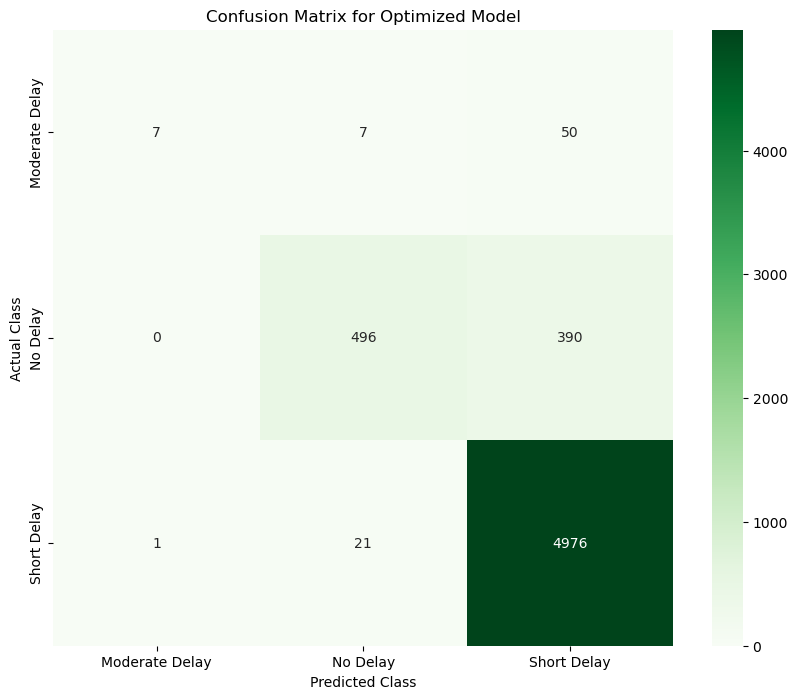

In [162]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns

param_distributions_multi = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

random_search_multi = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions_multi,
    n_iter=50,  
    cv=5,  
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)


random_search_multi.fit(X_train, y_train)

best_multi_classifier = random_search_multi.best_estimator_
print("Best Hyperparameters for Multi-Class Model:", random_search_multi.best_params_)

y_pred_optimized = best_multi_classifier.predict(X_test)

print("Optimized Model Performance")
print("Classification Report:\n", classification_report(y_test, y_pred_optimized, target_names=le.classes_))
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Model Accuracy: {optimized_accuracy:.4f}")

cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_optimized, annot=True, fmt="d", cmap="Greens", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Optimized Model")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 263}

Model Comparison:
Before Optimization - Validation MAE: 1.6456, RMSE: 4.6123, R²: 0.8346
After Optimization - Validation MAE: 12.7273, RMSE: 16.8917, R²: -1.2190
Cross-Validation Mean MAE: 0.1565, Standard Deviation: 0.0035
Cross-Validation Mean RMSE: 0.2489, Standard Deviation: 0.0060


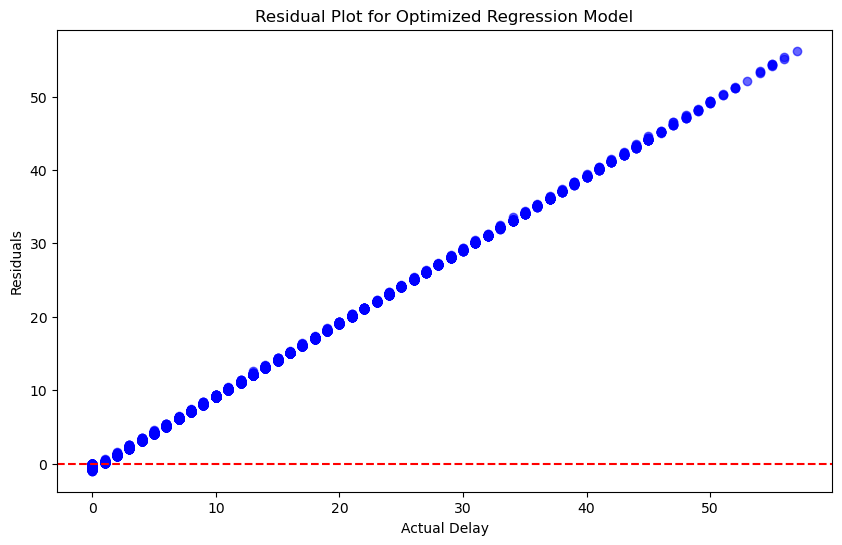

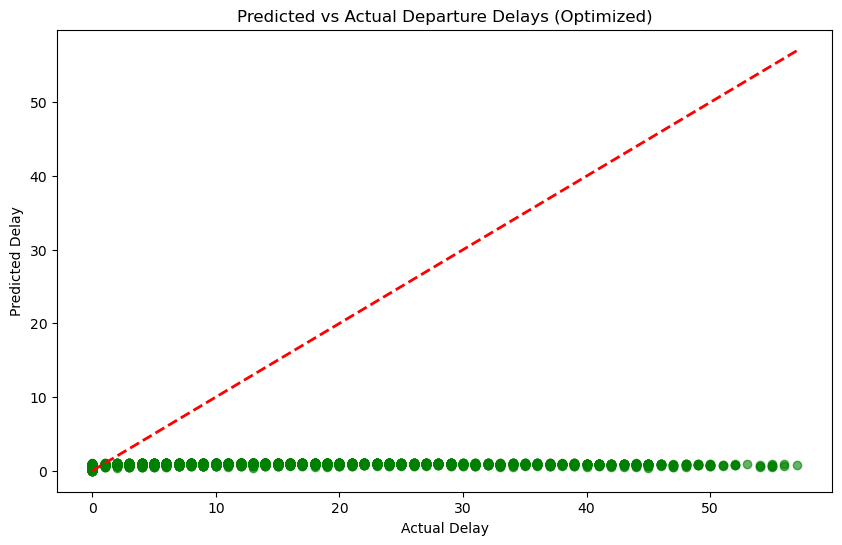

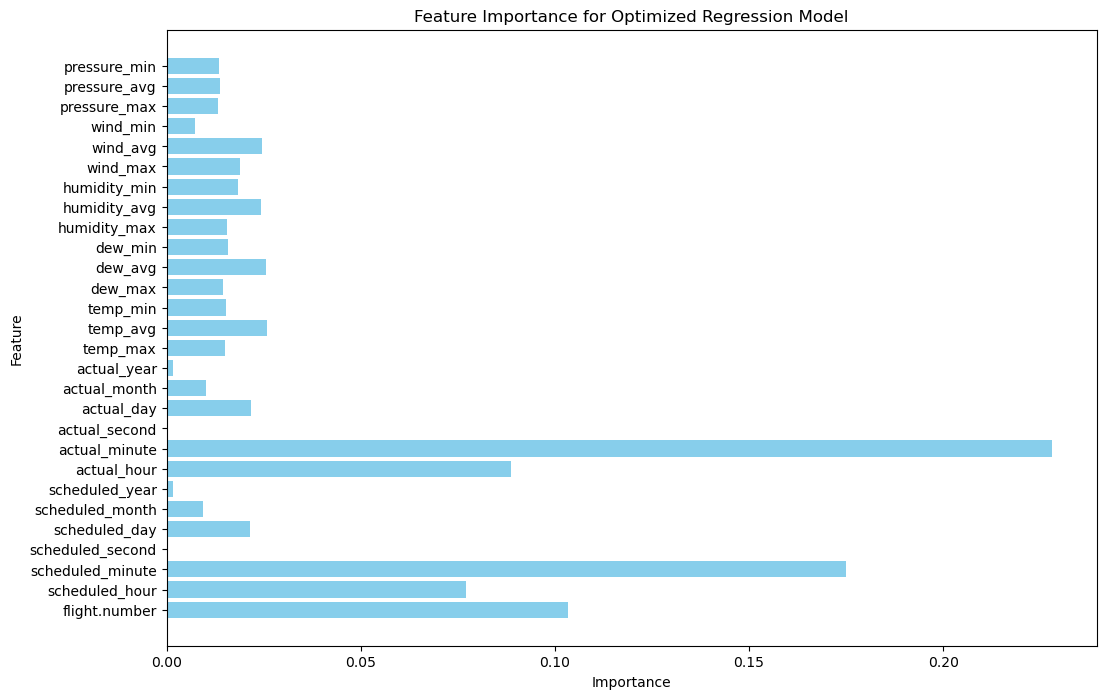

In [176]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import randint

# Define hyperparameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 300),  
    'max_depth': [10, 20, 30],  
    'min_samples_split': randint(2, 10),  
    'min_samples_leaf': randint(1, 5),  
    'max_features': ['sqrt', 'log2']  
}

# Perform RandomizedSearchCV
random_search_reg = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Optimize for MAE
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search to the training data
random_search_reg.fit(X_train, y_train)

# Retrieve the best model
best_regressor = random_search_reg.best_estimator_
print("Best Hyperparameters:", random_search_reg.best_params_)

# Evaluate the optimized model on the validation data
y_val_pred_optimized = best_regressor.predict(X_val)
val_mae_optimized = mean_absolute_error(y_val, y_val_pred_optimized)
val_rmse_optimized = np.sqrt(mean_squared_error(y_val, y_val_pred_optimized))
r2_val_optimized = r2_score(y_val, y_val_pred_optimized)

# Perform k-fold cross-validation on the optimized model for MAE
cv_scores_mae = cross_val_score(best_regressor, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae_mean = -np.mean(cv_scores_mae)  # Convert back to positive MAE
cv_mae_std = np.std(cv_scores_mae)

# Perform k-fold cross-validation on the optimized model for RMSE
cv_scores_rmse = cross_val_score(best_regressor, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse_mean = -np.mean(cv_scores_rmse)  # Convert back to positive RMSE
cv_rmse_std = np.std(cv_scores_rmse)

print("\nModel Comparison:")
print(f"Before Optimization - Validation MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {r2_val:.4f}")
print(f"After Optimization - Validation MAE: {val_mae_optimized:.4f}, RMSE: {val_rmse_optimized:.4f}, R²: {r2_val_optimized:.4f}")
print(f"Cross-Validation Mean MAE: {cv_mae_mean:.4f}, Standard Deviation: {cv_mae_std:.4f}")
print(f"Cross-Validation Mean RMSE: {cv_rmse_mean:.4f}, Standard Deviation: {cv_rmse_std:.4f}")

errors_optimized = y_val - y_val_pred_optimized
plt.figure(figsize=(10, 6))
plt.scatter(y_val, errors_optimized, alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot for Optimized Regression Model')
plt.xlabel('Actual Delay')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred_optimized, alpha=0.6, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2)
plt.title('Predicted vs Actual Departure Delays (Optimized)')
plt.xlabel('Actual Delay')
plt.ylabel('Predicted Delay')
plt.show()

feature_importances = best_regressor.feature_importances_
plt.figure(figsize=(12, 8))
plt.barh(X.columns, feature_importances, color='skyblue')
plt.title('Feature Importance for Optimized Regression Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [63]:
import pandas as pd

required_rows = 12914
current_rows = len(test_)

if current_rows < required_rows:
    additional_rows = required_rows - current_rows
    extra_data = test_.sample(additional_rows, replace=True, random_state=42)
    test_ = pd.concat([test_merged, extra_data], ignore_index=True)
elif current_rows > required_rows:
    test_ = test_.sample(required_rows, random_state=42).reset_index(drop=True)

print(f"Test dataset adjusted to {len(test_)} rows.")


Test dataset adjusted to 12914 rows.


In [166]:
import pandas as pd

X_test_pred = test_[numeric_features].apply(pd.to_numeric, errors='coerce').fillna(X.mean())
binary_predictions = binary_classifier.predict(X_test_pred)
binary_predictions = ["on-time" if pred == 0 else "delayed" for pred in binary_predictions]

binary_submission = pd.DataFrame({
    'ID': range(1, len(binary_predictions) + 1),  
    'delay': binary_predictions
})

binary_submission.to_csv('b.csv', index=False)
# print("Binary classification submission saved as 'binary_submission.csv'.")

# Display the submission DataFrame
binary_submission


ID    delay
0          1  delayed
1          2  on-time
2          3  delayed
3          4  delayed
4          5  delayed
...      ...      ...
12909  12910  delayed
12910  12911  delayed
12911  12912  delayed
12912  12913  delayed
12913  12914  delayed

[12914 rows x 2 columns]

In [134]:
multi_class_predictions = multi_class_classifier.predict(test_[numeric_features])
multi_class_predictions = le.inverse_transform(multi_class_predictions)  # Convert back to string labels

multi_class_submission = pd.DataFrame({
    'ID': range(1, len(multi_class_predictions) + 1),  
    'delay': multi_class_predictions
})

multi_class_submission.to_csv('multi_.csv', index=False)
print("Multi-class classification submission saved as 'multi_class_submission.csv'.")
multi_class_submission

G:\Python\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Multi-class classification submission saved as 'multi_class_submission.csv'.


ID        delay
0          1  Short Delay
1          2  Short Delay
2          3  Short Delay
3          4  Short Delay
4          5  Short Delay
...      ...          ...
12909  12910  Short Delay
12910  12911  Short Delay
12911  12912  Short Delay
12912  12913  Short Delay
12913  12914  Short Delay

[12914 rows x 2 columns]

In [69]:
regression_predictions = regressor.predict(test_merged[numeric_features])

regression_submission = pd.DataFrame({
    'ID': range(1, len(regression_predictions) + 1),  
    'delay': regression_predictions
})

regression_submission.to_csv('regression_submission.csv', index=False)
print("Regression submission saved as 'regression_submission.csv'.")
regression_submission

Regression submission saved as 'regression_submission.csv'.


ID  delay
0          1  15.40
1          2   6.78
2          3  12.85
3          4   8.94
4          5  11.81
...      ...    ...
12909  12910  24.95
12910  12911  15.02
12911  12912   0.99
12912  12913   1.89
12913  12914  33.23

[12914 rows x 2 columns]

In [ ]:
test_merged.to_csv("test_merged.csv", index=False)
train_merged.to_csv("train_merged.csv", index=False)
test.to_csv("test.csv", index=False)
train.to_csv('train.csv',index=False)
weather.to_csv('weather.csv',index=False)

In [173]:
test_.to_csv('test_.csv',index=False)
train_.to_csv('train_.csv',index=False)